In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np

tfd = tfp.distributions


In [7]:
url = ('https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

In [8]:
raw_df = pd.read_csv(url)

In [10]:
del raw_df['Lat']
del raw_df['Long']

In [13]:
df = raw_df.set_index(['Country/Region', 'Province/State']).transpose()
df = df.set_index(pd.to_datetime(df.index))

In [15]:
data = pd.DataFrame({c: df[c].sum(axis=1) for c in df.columns.get_level_values(0)})

Really messy, but this is the life of a data scientist.

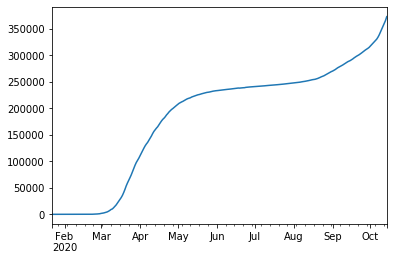

In [16]:
data['Italy'].plot()

Recovered means "not suseptible to the disease any more," whether you are dead or alive...

# SIR
$$\frac{dI}{dT} = \beta \frac{SI}{N} - \gamma I$$
Change of the number of infected over time $\beta$. 

The more infected people you have in society, the more they will infect. 

$SI$ because the more you have suseptible, the more you will infect, but  you need infected people in order to spread. 

Two parameters if the disease:
1. How quickly do new people get infected?
2. How quickly do they recover?

People recover faster than they get infected = $R<1$. 

$$
R = \frac{\beta}{\gamma}
$$

In [17]:
confirmed = data['Italy']
deltas = confirmed - confirmed.shift(1)

In [57]:
deltas

2020-01-22       NaN
2020-01-23       0.0
2020-01-24       0.0
2020-01-25       0.0
2020-01-26       0.0
2020-01-27       0.0
2020-01-28       0.0
2020-01-29       0.0
2020-01-30       0.0
2020-01-31       2.0
               ...  
2020-10-05    2257.0
2020-10-06    2677.0
2020-10-07    3677.0
2020-10-08    4458.0
2020-10-09    5372.0
2020-10-10    5724.0
2020-10-11    5456.0
2020-10-12    4619.0
2020-10-13    5898.0
2020-10-14    7332.0
Name: Italy, Length: 267, dtype: float64

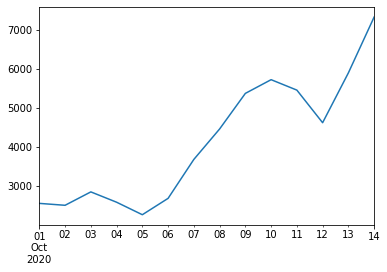

In [19]:
deltas['2020-10'].plot()

Peak in the weekend isn't real, but rather people take less tests during the weekends.

In [24]:
# ?deltas.rolling

In [28]:
pd.set_option('display.max_rows', 20)

In [30]:
ks = deltas.rolling(7, win_type='gaussian').mean(std=3).dropna().round()

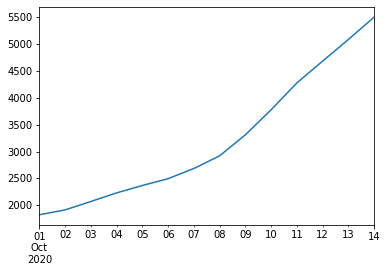

In [31]:
ks['2020-10'].plot()

# Simple model
Let's make a very simple model, no prior, and one parameter. Try out different values for this parameter to see which gives the mode probable model.

In [32]:
Rs = tf.linspace(0.5, 2., 1000)

It you think about it, $I$ (number of infected) is a sort of an exponential function. Wen need the slope of this exponential. 

In [46]:
models = tfd.Poisson(rate=ks['2020-10-04']*tf.exp((Rs-1)/5.2))   # this 5.2 is ca how long people are infected for before testing positive

We can now say, what is the probability of the case I am trying to predict (of infections for the next day).

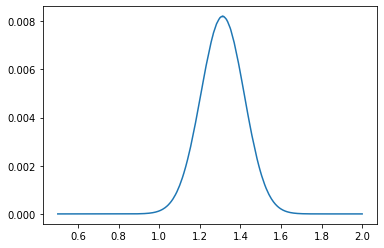

In [38]:
plt.plot(Rs, models.prob(ks['2020-10-05']))

In [39]:
ks['2020-10']

2020-10-01    1823.0
2020-10-02    1913.0
2020-10-03    2070.0
2020-10-04    2230.0
2020-10-05    2368.0
2020-10-06    2495.0
2020-10-07    2685.0
2020-10-08    2921.0
2020-10-09    3313.0
2020-10-10    3780.0
2020-10-11    4280.0
2020-10-12    4686.0
2020-10-13    5089.0
2020-10-14    5505.0
Name: Italy, dtype: float64

In [41]:
2368/2230

1.061883408071749

# Slightly more complicated model

In [58]:
model = tfd.JointDistributionNamed({
    'R': tfd.Normal(1.,.2), # prior on R
    'k': lambda R: tfd.Poisson(rate=ks['2020-10-04']*tf.exp(R-1./5.2))
})

In [59]:
model.resolve_graph()

(('R', ()), ('k', ('R',)))

In [60]:
model.sample()

{'R': <tf.Tensor: shape=(), dtype=float32, numpy=0.82795185>,
 'k': <tf.Tensor: shape=(), dtype=float32, numpy=4169.0>}

Here we see they chose a negative R. The value for k doesn't eve make sense to Dirk..

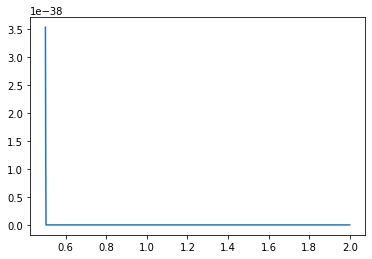

In [61]:
plt.plot(Rs, model.prob({'R': Rs, 'k': ks['2020-10-05']}))

Here, I dont get the same plot as he does. We went on before I could find the error.
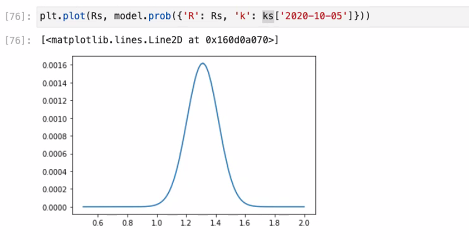

# MAP


In [54]:
R = tf.Variable(5.)
losses = tfp.math.minimize(lambda: -model.log_prob({'R': R, 'k':ks['2020-10-05']}),
                          num_steps=500,
                          optimizer=tf.optimizers.Adam(learning_rate=0.01))

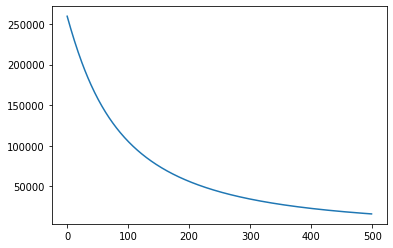

In [55]:
plt.plot(losses)

`math`only gives you the point estimate, but what you're really interested in is the (range?).


In [56]:
R

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.5545816>

# Multiple data points

Use yesterday's data as today's prior. 

In [62]:
tfd.Poisson([10, 20, 30]).sample()

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 6., 29., 27.], dtype=float32)>

In [64]:
ks['2020-10-04':'2020-10-06']  # with time seires, last index is included!

2020-10-04    2230.0
2020-10-05    2368.0
2020-10-06    2495.0
Name: Italy, dtype: float64

In [65]:
Tc = 5.2
ks_tf = tf.constant(ks['2020-10-04':'2020-10-06'], dtype=tf.float32) # just to be sure tensorflow doesn't get confused using a numpy array

Tensorflow likes using 32 float point bits, while numpy uses 64. Most graphic cards can't handle 64. 

In [66]:
?tfd.Independent

In [79]:
model = tfd.JointDistributionNamed({
    'R' :tfd.TruncatedNormal(loc=1, scale=3, low=0, high=10),   #prior on R
    'k': lambda R: tfd.Independent(
        tfd.Poisson(rate=ks_tf*tf.exp((R-1)/5.2)), 1)
})

In [72]:
model.sample()

{'R': <tf.Tensor: shape=(), dtype=float32, numpy=1.5448778>,
 'k': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([2476., 2696., 2708.], dtype=float32)>}

In [73]:
model.prob(model.sample())

<tf.Tensor: shape=(), dtype=float32, numpy=6.573528e-08>

In [80]:
model.prob({'R': 1.3, 'k':ks['2020-10-05':'2020-10-07']})

<tf.Tensor: shape=(), dtype=float32, numpy=7.292961e-08>

In [81]:
model.prob({'R': [1.3, 2], 'k':ks['2020-10-05':'2020-10-07']})

InvalidArgumentError: Incompatible shapes: [3] vs. [2] [Op:Mul]

In [82]:
model = tfd.JointDistributionNamed({
    'R' :tfd.TruncatedNormal(loc=1, scale=3, low=0, high=10),   #prior on R
    'k': lambda R: tfd.Independent(
        tfd.Poisson(rate=ks_tf*tf.exp((R[..., tf.newaxis]-1)/5.2)), 1)
})

In [83]:
model.prob({'R': [1.3, 2], 'k':ks['2020-10-05':'2020-10-07']})

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([7.2929609e-08, 7.4662397e-37], dtype=float32)>

In [84]:
def log_prob(R):
    return model.log_prob({'R': R, 'k':ks['2020-10-05':'2020-10-07']})

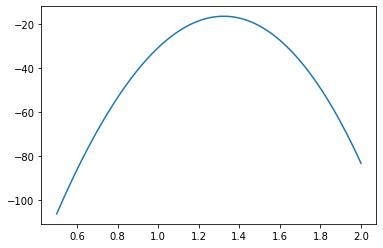

In [86]:
plt.plot(Rs, log_prob(Rs))

Now let's Monte Carlo this.

In [90]:
num_results = int(1e4)
num_burnin = int(1e4)

adaptive_hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob,
        num_leapfrog_steps=3,
        step_size=0.5),
    num_adaptation_steps = int(0.8*num_burnin)
)

# only thing diff. kernel within a kernel

In [104]:
@tf.function
def run_chain():
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin,
        current_state= np.ones((num_results, 1), dtype=np.float32),
        kernel=adaptive_hmc
    )

In [105]:
samples, kernel_results = run_chain()

C:\Users\perha\Anaconda3\lib\site-packages\tensorflow_probability\python\mcmc\sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [106]:
kernel_results.inner_results.is_accepted.np().sum(axis=0)/num_results

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'np'

In [ ]:
plt.hist(samples[:, 0,0].np(), bins=20)

In [ ]:
numpy.percentile(samples[:, 0, 0].np(), [])

Posterior sampling is somewhat weird, but very useful. (...)

In [ ]:
tf.math.exp((samples[:,0,0]-1)/Tc)